In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import cv2
import random
from random import shuffle
from torch.autograd import Variable
import sys
import pandas as pd

In [ ]:
data = []
labels = []
data_directory = "/content/drive/MyDrive/Colab Notebooks/APS360_Project/Final Labelled Images - Used"
characters = ['Buzz','Donald','Goofy', 'Mickey', 'Minnie','Pluto','Pumba','Simba','Tigger','Timon','Wall-e','Woody']
for character in characters:
  path = os.path.join(data_directory, character)
  label = characters.index(character)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
    img_array = np.array(img_array)
    img_array = img_array.astype('float32')
    img_array /= 255
    data.append([img_array, label])

np.random.seed(1000)
shuffle(data)
split1 = int(len(data) * 0.7)
split2 = int(len(data) * 0.85)

train_data = data[:split1]
valid_data = data[split1:split2]
test_data = data[split2:]


In [ ]:
batch_size = 512

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
from torch.nn.modules.activation import ReLU
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 4, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(4, 8, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(8, 16, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 7)
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(8, 4, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(4, 3, 3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid()
    )
  def forward(self, x):
      x = x.permute(0, 3, 2, 1)
      x = self.encoder(x)
      x = self.decoder(x)
      return x


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def plot_ae_outputs(model, path):

  buzz = []
  img_array = cv2.imread(path, cv2.IMREAD_COLOR)
  img_array = np.array(img_array)
  img_array = img_array.astype('float32')
  img_array /= 255
  buzz.append(img_array)

  batch_size = 1
  data_loader = torch.utils.data.DataLoader(buzz, batch_size=batch_size, shuffle=True)

  for images in data_loader:
    image = images[0]
    img = np.transpose(image, [0, 1, 2])
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original image')

    model = model.to(device)
    images = images.to(device)
    with torch.no_grad():
      output = model(images)
    recon = output[0]
    rcn = np.transpose(recon.cpu().detach().numpy(), [1, 2, 0])
    plt.subplot(1, 2, 2)
    angle = 270
    rcn = ndimage.rotate(rcn, angle, reshape=True)
    plt.imshow(rcn)
    plt.title('Reconstructed image')
    break


In [ ]:
#from torch.optim.optimizer import Optimizer
def train(model, data_loader, device, learning_rate=0.001):
  model = model.to(device)
  count = 0
  torch.manual_seed(0)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_loss = []

  for image_batch,_ in data_loader:
    image_batch = image_batch.to(device)
    output = model(image_batch)
    output = output.permute(0, 3, 2, 1)
    loss = criterion(output, image_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print('\t partial train loss (single batch): %f' % (loss.data))
    train_loss.append(loss.detach().cpu().numpy())

  return np.mean(train_loss)


def validate(model, dataloader, device):

  model = model.to(device)
  criterion = nn.MSELoss()
  model.eval()
  with torch.no_grad():

      conc_out = []
      conc_label = []
      for image_batch,_ in dataloader:

          image_batch = image_batch.to(device)
          output = model(image_batch)
          output = output.permute(0, 3, 2, 1)

          conc_out.append(output.cpu())
          conc_label.append(image_batch.cpu())
      # Create a single tensor with all the values in the lists
      conc_out = torch.cat(conc_out)
      conc_label = torch.cat(conc_label) 
      # Evaluate global loss
      val_loss = criterion(conc_out, conc_label)
  return val_loss.data
  

In [ ]:
import scipy.ndimage as ndimage
def get_accuracy(model, data, epoch):
  batch_size = 1
  data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

  for images,_ in data_loader:
    image = images[0]
    img = np.transpose(image, [0, 1, 2])
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original image')

    model = model.to(device)
    images = images.to(device)
    with torch.no_grad():
      output = model(images)
    recon = output[0]
    rcn = np.transpose(recon.cpu().detach().numpy(), [1, 2, 0])
    plt.subplot(1, 2, 2)
    angle = 270
    rcn = ndimage.rotate(rcn, angle, reshape=True)
    plt.imshow(rcn)
    plt.title('Reconstructed image')
    break

	 partial train loss (single batch): 0.135712
	 partial train loss (single batch): 0.134706
	 partial train loss (single batch): 0.134990
	 partial train loss (single batch): 0.139366
	 partial train loss (single batch): 0.128846
	 partial train loss (single batch): 0.132700
	 partial train loss (single batch): 0.131763
	 partial train loss (single batch): 0.132437
	 partial train loss (single batch): 0.132443
	 partial train loss (single batch): 0.133082
	 partial train loss (single batch): 0.137966
	 partial train loss (single batch): 0.130762
	 partial train loss (single batch): 0.131573
	 partial train loss (single batch): 0.130850
	 partial train loss (single batch): 0.129890
	 partial train loss (single batch): 0.127667
	 partial train loss (single batch): 0.133119

 EPOCH 1/1000 	 train loss 0.13281600177288055 	 val loss 0.12606419622898102
	 partial train loss (single batch): 0.128933
	 partial train loss (single batch): 0.127218
	 partial train loss (single batch): 0.126476
	

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Streaming output truncated to the last 5000 lines.
	 partial train loss (single batch): 0.015498

 EPOCH 737/1000 	 train loss 0.01642432250082493 	 val loss 0.016190096735954285
	 partial train loss (single batch): 0.015074
	 partial train loss (single batch): 0.020396
	 partial train loss (single batch): 0.015905
	 partial train loss (single batch): 0.017804
	 partial train loss (single batch): 0.017077
	 partial train loss (single batch): 0.016518
	 partial train loss (single batch): 0.016304
	 partial train loss (single batch): 0.015209
	 partial train loss (single batch): 0.017901
	 partial train loss (single batch): 0.014762
	 partial train loss (single batch): 0.015916
	 partial train loss (single batch): 0.017307
	 partial train loss (single batch): 0.015922
	 partial train loss (single batch): 0.015684
	 partial train loss (single batch): 0.016521
	 partial train loss (single batch): 0.015085
	 partial train loss (single batch): 0.015425

 EPOCH 738/1000 	 train loss 0.0164006

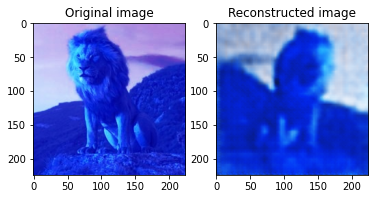

In [ ]:
num_epochs = 1000
model = Autoencoder()
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss = train(model, train_loader, device, learning_rate=0.001)
   val_loss = validate(model, valid_loader, device)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   get_accuracy(model, test_data, epoch)


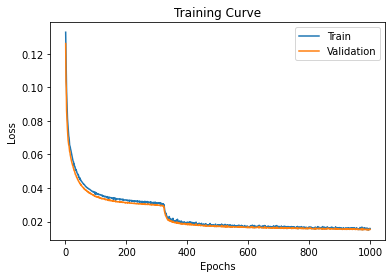

In [ ]:
# plotting

plt.title("Training Curve")
plt.plot(range(1, num_epochs+1), diz_loss['train_loss'], label="Train")
plt.plot(range(1, num_epochs+1), diz_loss['val_loss'], label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

In [ ]:
class LinearNet(nn.Module):
  def __init__(self):
    super(LinearNet, self).__init__()
    self.fc1 = nn.Linear(4096, 500)
    self.fc2 = nn.Linear(500, 64)
    self.fc3 = nn.Linear(64, 12)

  def forward(self,x):
    x = x.view(-1, 4096)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x

In [ ]:
def get_classifier_accuracy(model, loader):
  autoencoder = Autoencoder()
  autoencoder = autoencoder.to(device)
  model = model.to(device)
  correct = 0
  total = 0
  for imgs, label in loader:
    imgs = imgs.to(device)
    label = label.to(device)
    imgs = imgs.permute(0, 3, 2, 1)
    imgs = autoencoder.encoder(imgs)   
    output = model(imgs) 

    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(label.view_as(pred)).sum().item()
    total += imgs.shape[0]
  return correct / total

In [ ]:
from torch.types import Device
def train_classifier(model, train_loader, valid_loader, num_epochs=1):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    #autoencoder = Autoencoder()
    #model.convolution.load_state_dict(autoencoder.encoder.state_dict())

    iters, losses, train_acc, val_acc = [], [], [], []

    n = 0 
    for epoch in range(num_epochs):
      print(f'EPOCH: {epoch + 1}')
      for img_batch, labels in iter(train_loader):
        imgs = img_batch.to(device)
        labels = labels.to(device)
        imgs = imgs.permute(0, 3, 2, 1)

        autoencoder = autoencoder.to(device)

        imgs = autoencoder.encoder(imgs)   
        output = model(imgs) 
        #print(out.shape)  

        loss = criterion(output, labels)
        optimizer.zero_grad() 
        loss.backward()            
        optimizer.step()            
        print('\t partial train loss (single batch): %f' % (loss.data))       

        iters.append(n)
        losses.append(float(loss)/batch_size)             
        train_acc.append(get_classifier_accuracy(model, train_loader)) 
        val_acc.append(get_classifier_accuracy(model, valid_loader)) 
        n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

EPOCH: 1
	 partial train loss (single batch): 2.496937
	 partial train loss (single batch): 2.503170
	 partial train loss (single batch): 2.493715
	 partial train loss (single batch): 2.485273
	 partial train loss (single batch): 2.482287
	 partial train loss (single batch): 2.485959
	 partial train loss (single batch): 2.487662
	 partial train loss (single batch): 2.478452
	 partial train loss (single batch): 2.484886
	 partial train loss (single batch): 2.487922
	 partial train loss (single batch): 2.485293
	 partial train loss (single batch): 2.485477
	 partial train loss (single batch): 2.474869
	 partial train loss (single batch): 2.484508
	 partial train loss (single batch): 2.471841
	 partial train loss (single batch): 2.471469
	 partial train loss (single batch): 2.466646
EPOCH: 2
	 partial train loss (single batch): 2.474788
	 partial train loss (single batch): 2.470572
	 partial train loss (single batch): 2.476367
	 partial train loss (single batch): 2.465760
	 partial train 

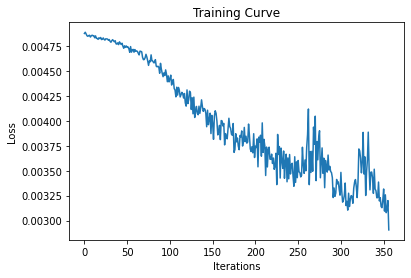

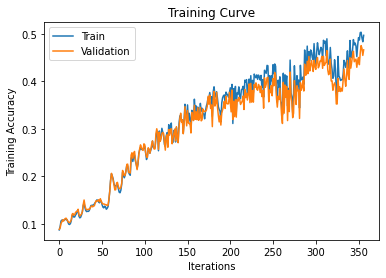

Final Training Accuracy: 0.49666666666666665
Final Validation Accuracy: 0.4661111111111111


In [ ]:

train_classifier(LinearNet(), train_loader, valid_loader, num_epochs=21)

In [ ]:
####### TEST ########
demon = []
char_label = []
data_directory = "/content/drive/MyDrive/Colab Notebooks/APS360_Project/Test"
characters = ['Buzz','Donald','Goofy','Mickey', 'Minnie','Pluto','Pumba','Simba','Tigger','Timon','Wall-e','Woody']
for character in characters:
  path = os.path.join(data_directory, character)
  char_label = characters.index(character)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
    img_array = np.array(img_array)
    img_array = img_array.astype('float32')
    img_array /= 255
    demon.append([img_array, char_label])

np.random.seed(1000)
shuffle(data)

In [ ]:
batch_size = 1

demon_loader = torch.utils.data.DataLoader(demon, batch_size=batch_size, shuffle=True)

output: Simba, label: Tigger
output: Simba, label: Buzz
output: Simba, label: Minnie
output: Simba, label: Simba
output: Simba, label: Donald
output: Woody, label: Goofy
output: Simba, label: Wall-e
output: Simba, label: Woody
output: Simba, label: Pluto
output: Simba, label: Pumba
output: Wall-e, label: Timon
output: Simba, label: Mickey


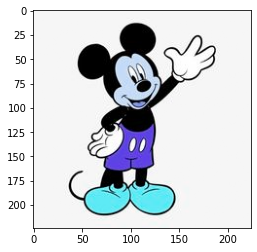

In [ ]:
final_model = LargeNet()
n=0
for imgs, label in demon_loader:
  imgs = imgs.permute(0, 3, 2, 1)
  output = final_model(imgs) 
  #print("Classes order: '[Buzz, Donald, Goofy, Minnie, Pluto, Pumba, Simba, Tigger, Timon, Wall-e, Woody]'")
  print(f'output: {characters[output.max(1, keepdim=True)[1]]}, label: {characters[label]}')
  imgs = imgs[0]
  imgs = np.transpose(imgs, [2, 1, 0])
  plt.imshow(imgs)